In [ ]:
import json
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
# Load the trajectory file
with open('received_trajectory.txt', 'r', encoding='utf-8') as file:
    data = json.load(file)  # read the entire file and parse it as JSON

# Inspect the top-level keys
print("Top-level JSON keys:", data.keys())

# Retrieve the start position (lat, lon)
start_position = (data['startPosition']['lat'], data['startPosition']['long'])
print("Start Position:", start_position)

# Retrieve all GNSS (or fusion) data points
gnss_list = data.get('gnssData', [])
print("Number of GNSS data points:", len(gnss_list))

# Filter out only those entries that match your 'fusion' provider
tagging_list = [item for item in gnss_list if item.get('provider') == 'fusion']

# Construct a list of (latitude, longitude) tuples from these tagged points
lat_lon_list = [
    (item['latitude'], item['longitude'])
    for item in tagging_list
    if 'latitude' in item and 'longitude' in item
]
print("Predicted (lat, lon) points:", lat_lon_list)


Top-level JSON keys: dict_keys(['androidVersion', 'imuData', 'pdrData', 'positionData', 'pressureData', 'lightData', 'gnssData', 'wifiData', 'apsData', 'startTimestamp', 'accelerometerInfo', 'gyroscopeInfo', 'magnetometerInfo', 'barometerInfo', 'lightSensorInfo', 'startPosition', 'fusionData'])
Start Position: (55.9231, -3.1742742)
Number of GNSS data points: 30
Predicted (lat, lon) points: [(55.92302, -3.1741936), (55.92292, -3.1741865), (55.922916, -3.1743038), (55.923027, -3.1742878)]


In [3]:
ground_truth = [
    (55.92302417892292, -3.1741890216007107), # tr
    (55.922917910116, -3.1741892360311152), # br
    (55.92291795573684, -3.174298939023905), # bl
    (55.92302422452443, -3.174298724903236), # tl    
]



def haversine(coord1, coord2):
    """
    Compute the Haversine distance (in meters) between two lat/lon coordinates.
    """
    R = 6371000  # Earth's radius (meters)
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (math.sin(dlat/2)**2
         + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def geo_to_xy(ref, point):
    """
    Convert latitude/longitude into local x, y coordinates (in meters)
    relative to a reference latitude/longitude.
    """
    lat_ref, lon_ref = ref
    lat, lon = point
    # Approximate conversions:
    dx = (lon - lon_ref) * 111320 * np.cos(np.radians(lat_ref))
    dy = (lat - lat_ref) * 110540
    return dx, dy


In [4]:
# Compute absolute (Haversine) errors for each predicted vs. ground truth
errors = []
for pred, truth in zip(lat_lon_list, ground_truth):
    abs_err = haversine(pred, truth)
    errors.append(abs_err)

# Compute the distance between the first and last ground truth points
# as a global reference distance (for demonstration)
ref_dist = haversine(ground_truth[0], ground_truth[-1])

# Compute relative errors (percentage) vs. this global reference distance
relative_errors = [(e / ref_dist) * 100 for e in errors]

# Create a DataFrame to organize results
df = pd.DataFrame({
    'Predicted_Lat': [p[0] for p in lat_lon_list],
    'Predicted_Lon': [p[1] for p in lat_lon_list],
    'True_Lat': [t[0] for t in ground_truth],
    'True_Lon': [t[1] for t in ground_truth],
    'Absolute_Error_m': errors
})

# Compute pairwise relative errors:
# The 'reference distance' here is the distance between consecutive GT points
relative_errors_pairwise = [None]  # The first point has no previous neighbor

for i in range(1, len(ground_truth)):
    segment_dist = haversine(ground_truth[i - 1], ground_truth[i])
    rel_err = (errors[i] / segment_dist) * 100 if segment_dist != 0 else None
    relative_errors_pairwise.append(rel_err)

df['Relative_Error_Pairwise_%'] = relative_errors_pairwise

# Display the result table
df


,Predicted_Lat,Predicted_Lon,True_Lat,True_Lon,Absolute_Error_m,Relative_Error_Pairwise_%
0,55.923020,-3.174194,55.923024,-3.174189,0.545243,NaN
1,55.922920,-3.174186,55.922918,-3.174189,0.288202,2.438969
2,55.922916,-3.174304,55.922918,-3.174299,0.372845,5.455047
3,55.923027,-3.174288,55.923024,-3.174299,0.747355,6.324638


In [5]:

# Extract the recorded (x, y) path from the JSON (if available)
xy_coords = [(0, 0)] + [(item['x'], item['y']) for item in data['fusionData']]

# Convert lat/lon predictions and ground truths to local x, y (meters)
fused_xy = [geo_to_xy(start_position, p) for p in lat_lon_list]
true_xy  = [geo_to_xy(start_position, t) for t in ground_truth]

# Separate out the x, y lists
xvals = [coord[0] for coord in xy_coords]
yvals = [coord[1] for coord in xy_coords]

# Create the plotly figure
fig = go.Figure()

# Add estimated trajectory line
fig.add_trace(go.Scatter(
    x=xvals, y=yvals,
    mode='lines',
    name='Estimated Trajectory (x,y)',
    line=dict(width=2)
))

# Add predicted points
fused_x, fused_y = zip(*fused_xy)
fig.add_trace(go.Scatter(
    x=fused_x, y=fused_y,
    mode='markers',
    name='Predicted Points',
    marker=dict(size=8)
))

# Add ground truth points
true_x, true_y = zip(*true_xy)
fig.add_trace(go.Scatter(
    x=true_x, y=true_y,
    mode='markers',
    name='Ground Truth Points',
    marker=dict(symbol='star', size=12)
))

fig.update_layout(
    title='Trajectory vs. Fusion/Ground Truth Points',
    xaxis_title='X Direction (m)',
    yaxis_title='Y Direction (m)',
    legend=dict(x=0, y=1),
    xaxis=dict(scaleanchor='y'),
    yaxis=dict(),
    width=800,
    height=600,
    # paper_bgcolor='rgba(0,0,0,0)',  # transparent paper background
    # plot_bgcolor='rgba(0,0,0,0)'    # transparent plot background
)


fig.show()

# pio.write_image(fig, "trajectory.png", format='png', width=800, height=600, scale=2, engine='kaleido') # Save as PNG


RMSE (m): 0.5191104914815435
Mean Absolute Error (m): 0.48841125212570224
Std Dev of Error (m): 0.17586969938910274
Minimum Error (m): 0.28820222320661415
Maximum Error (m): 0.7473545352785772
Median Error (m): 0.45904412500880887


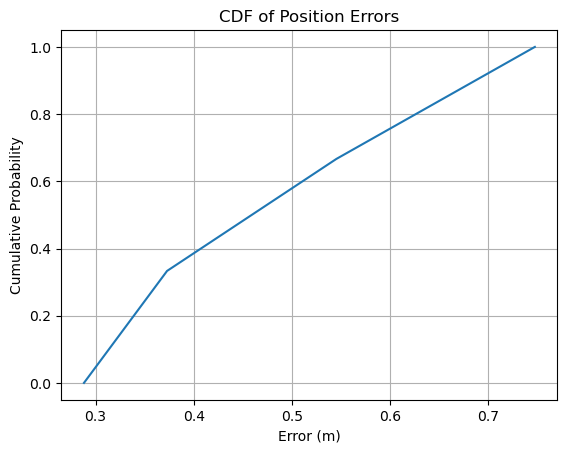

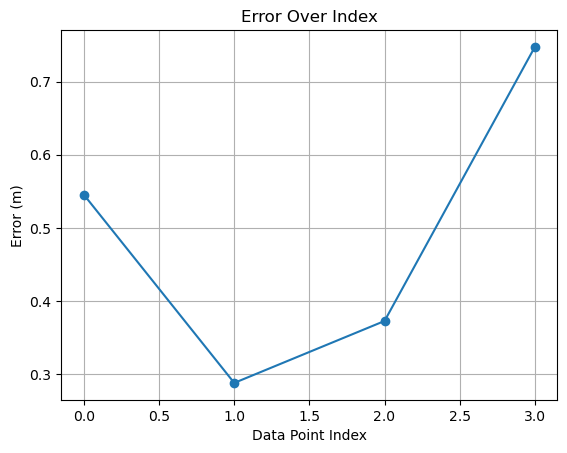

In [ ]:
#####################################
# Extended Error Evaluation
#####################################

# error metrics
rmse = np.sqrt(np.mean([e**2 for e in errors]))
mae  = np.mean(errors)
std_dev = np.std(errors)
min_err = np.min(errors)
max_err = np.max(errors)
median_err = np.median(errors)

print("RMSE (m):", rmse)
print("Mean Absolute Error (m):", mae)
print("Std Dev of Error (m):", std_dev)
print("Minimum Error (m):", min_err)
print("Maximum Error (m):", max_err)
print("Median Error (m):", median_err)

# 2. Create a CDF plot
sorted_errors = np.sort(errors)
cdf_yvals = np.arange(len(sorted_errors)) / (len(sorted_errors) - 1)

plt.figure()
plt.plot(sorted_errors, cdf_yvals)
plt.xlabel("Error (m)")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Position Errors")
plt.grid(True)
plt.show()

# 3. Plot error over points or time if you have timestamps
plt.figure()
plt.plot(errors, marker='o')
plt.title("Error Over Index")
plt.xlabel("Data Point Index")
plt.ylabel("Error (m)")
plt.grid(True)
plt.show()
